Рассматривается простейшая СМО с практически неограниченным числом каналов (п —> оо). На вход СМО поступает поток заявок с интенсивностью X; интенсивность потока обслуживании (для одного канала) равна 1/tобсл. Найти финальные вероятности состояний СМО и среднее число занятых каналов к. 1/tобсл

In [1]:
import bisect
import json
import math
import matplotlib.pyplot as plt 
import random
from enum import Enum, auto


class EventType(Enum):
    INCOMING_REQ = auto()
    REQ_PROCESSED = auto()
    
    
class Event:
    
    def __init__(self, type, info=None):
        self.type = type
        self.info = info or dict()
    
    def __str__(self):
        return f"({self.type}, {self.info})"

In [2]:
class Model:

    def finalize_stats(self, T: float) -> dict:
        
        self.stats['mean_busy_channels'] = sum(num*t for num, t in self.stats['states'].items()) / T
        
        self.stats['mean_time_in_smo'] = self.stats['time_in_process'] / self.stats['overall_requests']
        # финальные вероятности состояний
        self.stats['states'] = {num: t / T for num, t in self.stats['states'].items()}

        return self.stats
    
    def reset(self):
        # состояние СМО
        self.state = 0 
        # sorted list of tuples (time_point, Event)
        self.horizon = []
        
        self.stats = {}
        # значения - кол-во времени, проведённое в заданном состоянии
        self.stats['states'] = {}
        self.stats['time_in_process'] = 0
        self.stats['overall_requests'] = 0
        
    def __init__(self, request_intensity, mean_serve_time, theory_states=[]):
        
        # these will be passed as `lambd` to `generate_exponential_input`/`generate_puasson_stream`
        self.request_intensity = request_intensity
        self.serve_intensity = 1 / mean_serve_time
        
        self.theory_states = theory_states
        
        self.reset()
        
    @staticmethod
    def gen_exp_input(lambd: float):
        return -1 / lambd * math.log(random.random())
    
    def random_serve_time(self):
        return self.gen_exp_input(self.serve_intensity)
    
    def random_q_wait_time(self):
        return self.gen_exp_input(self.queue_wait_intensity)
        
    @staticmethod
    def gen_puasson_stream(lambd: float, T: int) -> list:
        """Args:
            lambda: интенсивность потока
            T: конец интервала (0, T], для которого нужно сгенерировать паусоновский поток
        """
        stream = []
        t = 0
        while 1:
            tau = Model.gen_exp_input(lambd)
            t += tau
            if t > T:
                return stream
            stream.append(t)
        return stream
    
    def add_event(self, time_point: float, event: Event):
        bisect.insort(self.horizon, (time_point, event))
    
    def add_request(self, current_time_point):
        done_time_point = current_time_point + self.random_serve_time()
        self.add_event(done_time_point, 
                       Event(EventType.REQ_PROCESSED,
                             {'start_processing': current_time_point}))
    
    def save_states_time(self, time: float):
        self.stats['states'][self.state] = self.stats['states'].get(self.state, 0) + time
        
    def run(self, T: float) -> dict:
        """Args:
                T: длительность имитации СМО
           Returns:
               dict: словарь со всеми статистиками
        """
        self.reset()
        requests_stream = self.gen_puasson_stream(self.request_intensity, T)
        self.horizon = [(r, Event(EventType.INCOMING_REQ)) for r in requests_stream]
            
        t = 0
        while t <= T and self.horizon:
            time_point, event = self.horizon.pop(0)
            self.save_states_time(time_point - t)
            if event.type == EventType.INCOMING_REQ:
                self.stats['overall_requests'] += 1
                self.add_request(time_point)
                self.state += 1        
            else:  # event.type == EventType.REQ_PROCESSED:
                self.stats['time_in_process'] += time_point - event.info['start_processing']
                self.state -= 1 
            t = time_point
        self.save_states_time(T - t)
        
        return self.finalize_stats(T)

In [3]:
class TheoryStats:
        
    def __init__(self, request_intensity, mean_serve_time, states_num):
        self.lambd = request_intensity
        self.mu = 1 / mean_serve_time
        self.alpha = request_intensity * mean_serve_time
        
        self.states_num = states_num
    
    def calculate_final_probs(self):
        p0 = math.exp(-self.alpha)

        states[0] = p0
        for k in range(1, self.n+1):
            states[k] = self.alpha ** k / math.factorial(k) * p0
        for s in range(1, self.m+1): 
            product = 1
            for m in range(1, s+1):
                product *= self.n + m * self.beta
            states[self.n+s] = states[self.n] * self.alpha ** (s) / product
        self.states = states
    
    def generate(self) -> dict:
        p0 = math.exp(-self.alpha)
        stats = {}
        stats['states'] = {i: self.alpha ** i / math.factorial(i) * p0 for i in range(self.states_num+1)}
        stats['mean_busy_channels'] = self.alpha
        stats['mean_time_in_smo'] = 1 / self.mu
        return stats

/home/frantic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


empirical stats
{
  "time_in_process": 312222.7750979762,
  "overall_requests": 62433,
  "mean_busy_channels": 6.244639740568317,
  "mean_time_in_smo": 5.000925393589547
}
theory stats
{
  "mean_busy_channels": 6.25,
  "mean_time_in_smo": 5.0
}


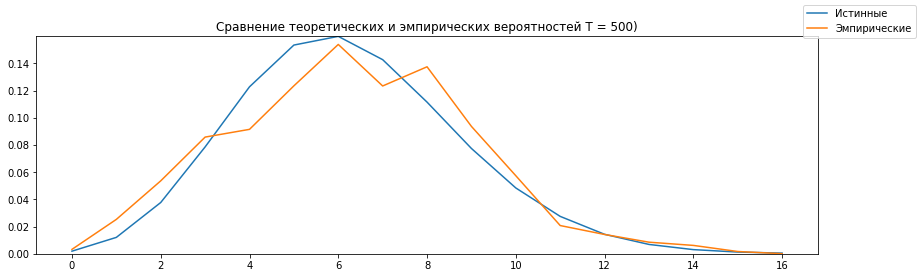

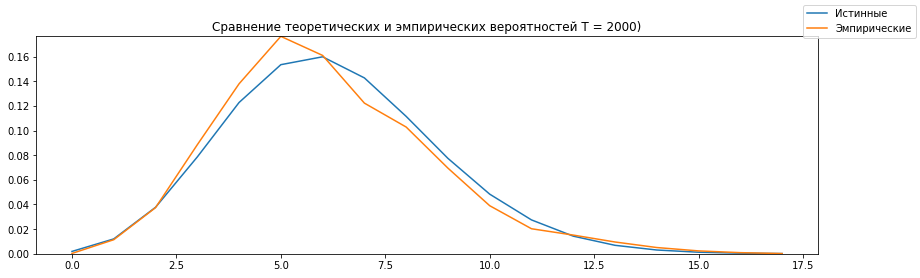

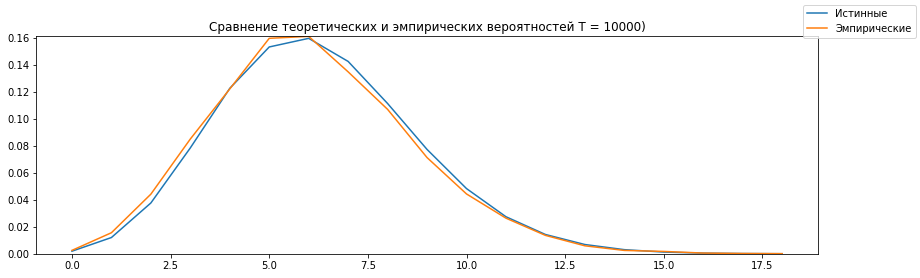

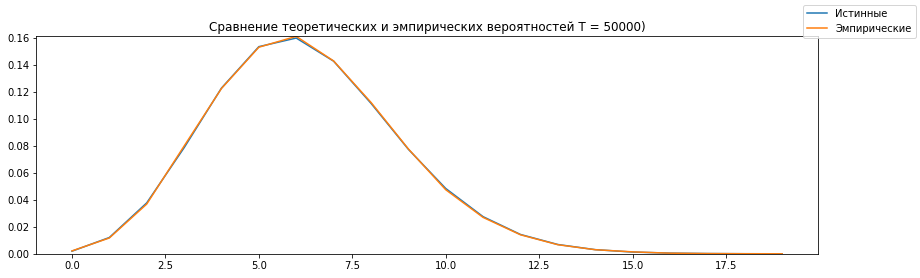

In [5]:
for T in (500, 2000, 10000, 50000):
    kwargs = {
        'request_intensity': 1.25,
        'mean_serve_time': 5,
    }
    model = Model(**kwargs)
    empirical_stats = model.run(T)

    kwargs['states_num'] = max(empirical_stats['states'].keys())
    theory_stats = TheoryStats(**kwargs).generate()

    theory_states = theory_stats.pop('states')
    empirical_states = empirical_stats.pop('states')

    fig, ax = plt.subplots(figsize=(14, 4))
    ax.set_title(f"Сравнение теоретических и эмпирических вероятностей T = {T})")
    ax.set_ylim([0.0, max(max(empirical_states.values()), max(theory_states.values()))])
    xs = list(range(kwargs['states_num']+1))
    ax.plot(xs,
            theory_states.values(),
            label='Истинные')
    ax.plot(xs,
            empirical_states.values(),
            label='Эмпирические')
    fig.legend()
    fig.show()
print(f"empirical stats\n{json.dumps(empirical_stats, indent=2)}")
print(f"theory stats\n{json.dumps(theory_stats, indent=2)}")